# Comparison of Salmon-based PolII CRAC quantification with tRNA-level data from Tomek

**Samples**
- BY4741 + 128 kb neochromosome (+ Rpo31/Rpc160)
- BY4741 + pRS415 (+ Rpo31/Rpc160)
- BY4741 (- Rpo31/Rpc160)

Rpo31/Rpc160 is largest catalytic subunit of RNAPIII. HTP-tagged for CRAC. 

# Sample naming

- **Salmon-CRAC**: Salmon quantification of CRAC-Seq data
- **Alignment-CRAC**: Alignment-based (NovoAlign) quantification of CRAC-Seq data

## Load libraries/data

<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>

In [1]:
options(warn=-1)
#options(warn=0)
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
options(jupyter.plot_mimetypes = 'image/png')
suppressMessages(devtools::source_url("https://raw.githubusercontent.com/scalefreegan/R-tools/master/defaultRlibs.R"))
suppressMessages(library(forcats))

In [2]:
GENOME = "/g/steinmetz/project/IESY/genomes/"
# load ncRNA annotations
load("/g/steinmetz/project/IESY/trna/data/ncRNA_annotations.rda")

RESULTS = "/g/steinmetz/project/IESY/trna/results/polIIIcrac"
# load neo2wt tRNA annotations
mf = "/g/steinmetz/project/IESY/genomes/annotations/trna_neo2wt_match.rds"
chr18_wt_match <- readRDS(mf)
# load tRNA sim
sf = "/g/steinmetz/project/IESY/trna/allncrnas_stringdistmatrix.rda"
load(sf)
allstringdistmatrix = allstringdistmatrix %>% mutate(x = gsub("^WT\\.","",x),x = gsub("^SYN\\.","",x),
                                    y = gsub("^WT\\.","",y),y = gsub("^SYN\\.","",y))
f2 = "/g/steinmetz/project/IESY/genomes/annotations/trna_neo2wt_NOmatch.rds"
seq_nomatch <- readRDS(f2)

sample2ezname = function(x) {
    o = x
    o[x == "S1"] = "BY4741-neg"
    o[x == "S2"] = "BY4741"
    o[x == "S3"] = "BY4741+neo"
    return(o)
}

sf = file.path(RESULTS,"results.rds")
results <- readRDS(sf)

# load data from tomek
tf1 = "/g/steinmetz/project/IESY/trna/results/polIIIcrac/tomek_data/trna_crac.txt"
tf2 = "/g/steinmetz/project/IESY/trna/results/polIIIcrac/tomek_data/trna_crac_random.txt"
trna_crac = readr::read_delim(tf1, delim = "\t")
colnames(trna_crac)[colnames(trna_crac)=="Rpc160HTP_wt_none"] = "wt"
colnames(trna_crac)[colnames(trna_crac)=="04_TT16612_BY4741"] = "none"
colnames(trna_crac)[colnames(trna_crac)=="Rpc160HTP_Neo_none"] = "neo"
trna_crac_random = readr::read_delim(tf2, delim = "\t")

# pair WT-neo chr samples using neo2wt annotations
# keep all tRNAs regardless of whether they have 
# a cognate tRNA on the neochr
trna_pair_quant = chr18_wt_match %>% select(note,Name.x,Name.y,aa,anticodon) %>% rowwise() %>% do({
    thisrow = .
    mrows.x = results %>% filter(Name == thisrow$Name.x)
    mrows.y = results %>% filter(Name == thisrow$Name.y)
    mrows = merge(mrows.x, mrows.y, by = "sample", all = T)
    x = filter(allstringdistmatrix, x==thisrow$Name.x, type=="whole")
    x.y = filter(x, x==thisrow$Name.x, y==thisrow$Name.y, type=="whole")
    if (dim(x.y)[1]>0) {
        lt = filter(x, norm.value <= x.y$norm.value)
        sim.count = dim(lt)[1]
    } else {
        sim.count = 0
    }
    #print(c(thisrow$Name.x,thisrow$Name.y))
    o = data.frame(Name.x = thisrow$Name.x,
                   Name.y = thisrow$Name.y,
                   note = thisrow$note,
                   aa = thisrow$aa,
                   anticodon = thisrow$anticodon,
                   TPM.x = mrows$TPM.x,
                   NumReads.x = mrows$NumReads.x,
                   TPM.y = mrows$TPM.y,
                   NumReads.y = mrows$NumReads.y,
                   sample = mrows$sample,
                   sim.count,
                   stringsAsFactors = F
                  )
    }) %>% mutate(ezsample = sample2ezname(sample)) %>% 
    mutate(intron = factor(note %in% seq_nomatch$note))

Parsed with column specification:
cols(
  gene_name = col_character(),
  gene_id = col_character(),
  type = col_character(),
  Rpc160HTP_wt_none = col_integer(),
  `04_TT16612_BY4741` = col_integer(),
  Rpc160HTP_Neo_none = col_integer()
)
Parsed with column specification:
cols(
  gene_name = col_character(),
  gene_id = col_character(),
  type = col_character(),
  BY4741_mock_random = col_integer(),
  BY_Rpc160HTP_wt = col_integer(),
  BY_Rpc160HTP_Neo = col_integer()
)


## Annotate Salmon results with CRAC-names

In [3]:
salmon_quant = trna_pair_quant %>% rowwise() %>% do({ 
    data.frame(note = c(paste("Neo",.$note,sep="_"),.$note), 
               salmon.TPM = c(.$TPM.x,.$TPM.y),
              salmon.NumReads = c(.$NumReads.x,.$NumReads.y),
              sample = .$sample,
              ezsample = .$ezsample)
})

## I am missing a few tRNAs, especially mitochondrial

A small number of tRNAs annotated in the CRAC data are missing in my transcript annotation database. What are these?

In [21]:
missing = trna_crac$gene_id[!trna_crac$gene_id%in%salmon_quant$note]
cat("tRNAs missing from Salmon transcript reference database, but present in CRAC-Seq quantification from Tomek:")
missing

tRNAs missing from Salmon transcript reference database, but present in CRAC-Seq quantification from Tomek:

[1] "tC(GCA)Q"  "tP(UGG)Q"  "tS(GCU)Q1" "tT(XXX)Q2" "tY(GUA)Q"  "tS(GCU)L"

In [5]:
filter(trna_crac, gene_id %in% missing)

,gene_name,gene_id,type,wt,none,neo
1,tC(GCA)Q,tC(GCA)Q,tRNA,0,0,0
2,tP(UGG)Q,tP(UGG)Q,tRNA,0,0,0
3,tS(GCU)Q1,tS(GCU)Q1,tRNA,0,0,0
4,tT(XXX)Q2,tT(XXX)Q2,tRNA,0,0,0
5,tY(GUA)Q,tY(GUA)Q,tRNA,0,0,0
6,tS(GCU)L,tS(GCU)L,tRNA,541,0,206


**Conclusion**: I don't think these missing tRNAs are a problem.

5/6 missing tRNAs (all on the mitochondria) do not appear to be in the BY4741 genome based on my *de novo* tRNA detection with `tRNAscan-SE` using the BY4741 genome. Their absence is substaintiated by **0** quantification in all samples tested.

The **tS(GCU)L** is not annotated by SGD. Should it be added as a real tRNA? I cannot currently find significant substantiated evidence for its inclusion.

## Merge Salmon and CRAC results for plotting

In [6]:
sample2ezname2 = function(x) {
    if (class(x)=="factor")
    o = levels(x)[x]
    o[x == "none"] = "BY4741-neg"
    o[x == "wt"] = "BY4741"
    o[x == "neo"] = "BY4741+neo"
    return(o)
}
crac = melt(trna_crac,variable.name = "crac_sample", stringsAsFactors = F) %>% 
    mutate(ezsample = sample2ezname2(crac_sample))

Using gene_name, gene_id, type as id variables


In [7]:
df.merge = merge(salmon_quant,crac,
                 by.x=c("note","ezsample"),by.y=c("gene_id","ezsample"))
df.merge = df.merge %>% mutate(Neo = grepl("Neo", note))

In [8]:
options(repr.plot.width = 4)
options(repr.plot.height = 2)
p1.1 <- ggplot(df.merge %>% filter(ezsample == "BY4741+neo" & crac_sample == "neo")) +
    geom_point(aes(x = salmon.NumReads+1, y = value+1, color = Neo, fill=Neo)) + 
    scale_y_continuous(trans="log2", limits = c(1,32768)) + 
    scale_x_continuous(trans="log2", limits = c(1,32768)) +
    xlab("Salmon-CRAC, NumReads") +
    ylab("Alignment-CRAC Quant") +
    ggtitle("BY4741+neo") + geom_abline(intercept=0, slope=1)
p1.1 <- ggExtra::ggMarginal(p1.1, type = "histogram",size = 10)

p1.2 <- ggplot(df.merge %>% filter(ezsample == "BY4741" & crac_sample == "wt")) +
    geom_point(aes(x = salmon.NumReads+1, y = value+1, color = Neo)) + 
    scale_y_continuous(trans="log2", limits = c(1,32768)) + 
    scale_x_continuous(trans="log2", limits = c(1,32768)) +
    xlab("Salmon-CRAC, NumReads") +
    ylab("Alignment-CRAC Quant") +
    ggtitle("BY4741") + geom_abline(intercept=0, slope=1)
p1.2 <- ggExtra::ggMarginal(p1.2, type = "histogram",size = 10)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


# Figure 1: Salmon CRAC vs. CRAC-Seq quantification with and without neochromosome

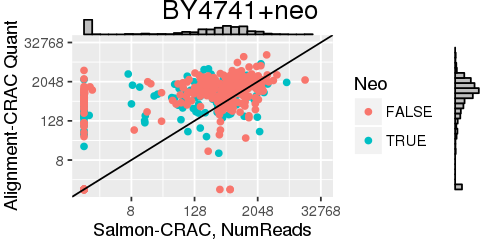

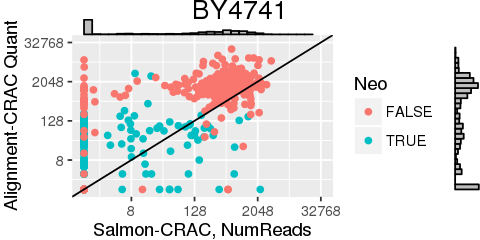

In [9]:
p1.1 
p1.2

In [10]:
cat("BY4741+neo")
df.merge %>% filter(ezsample == "BY4741+neo", 
                    crac_sample == "neo",
                    salmon.NumReads > 0) %>% 
    summarise(cor = cor(log2(salmon.NumReads+1),log2(value+1)))
cat("BY4741")
df.merge %>% filter(ezsample == "BY4741",
                    crac_sample == "wt",
                    salmon.NumReads > 0) %>% 
summarise(cor = cor(log2(salmon.NumReads+1),log2(value+1)))

BY4741+neo

,cor
1,0.2359904


BY4741

,cor
1,0.4764171


Salmon-CRAC and  alignment-CRAC quantifications are weakly correlated. 

- A large number of tRNAs (from the neochr and native genome) are not quantified by Salmon (Salmon quant ~= 0). Perhaps this is because of short-read lengths? Unclear why.
- Salmon does a better job at misquantification. Fewer tRNAs from neochr with >0 quantification in strain w/o neochr

In [11]:
syn.tot = dim(unique(df.merge %>% filter(Neo==T, sample=="S2") %>% select(note)))[1]

misquant = df.merge %>% filter(Neo==T,sample=="S2") %>%
    summarise(salmon.crac = sum(as.numeric(salmon.TPM)>0, na.rm = T)/syn.tot,
             alignment.crac = sum(as.numeric(value)>0, na.rm = T)/syn.tot)

p2 <- ggplot(melt(misquant), aes(x=factor(variable), y=value)) + geom_bar(stat="identity") + 
    ylim(c(0,1)) + ylab("Misquantification rate") + xlab("") + 
    ggtitle("Misquantification rates:\n Salmon-CRAC vs. Alignment-CRAC")


No id variables; using all as measure variables


# Figure 2: Salmon-CRAC has lower misquantification rate

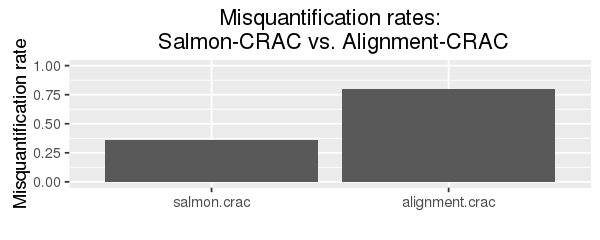

In [12]:
options(repr.plot.width = 5, repr.plot.height = 2)
p2

Misquantification rate (fraction of neochr tRNAs with nonzero quantification in BY4741 sample: - neochr) is half as much in Salmon quantification compared to alignment-based approach.

## How different are alignment-CRAC quantifications across samples?

Are the differences in quantification between Salmon- and alignment-CRAC higher or lower in magnitude compared to differences between samples quantified by alignment-CRAC

In [13]:
trna_crac = trna_crac %>% mutate(neo.chr=grepl("Neo",gene_id))

In [14]:
p3 <- ggplot(trna_crac, aes(x = wt+1, y = neo+1, color = neo.chr)) +
    geom_point() + 
    scale_y_continuous(trans="log2", limits = c(1,32768)) + 
    scale_x_continuous(trans="log2", limits = c(1,32768)) +
    xlab("Alignment-CRAC, BY4741") +
    ylab("Alignment-CRAC, BY4741+Neo") +
    ggtitle("CRAC Quantification across samples")
p3 <- ggExtra::ggMarginal(p3, type = "histogram",size = 10)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


# Figure 3:  Reproducibility of Alignment-CRAC seq across samples

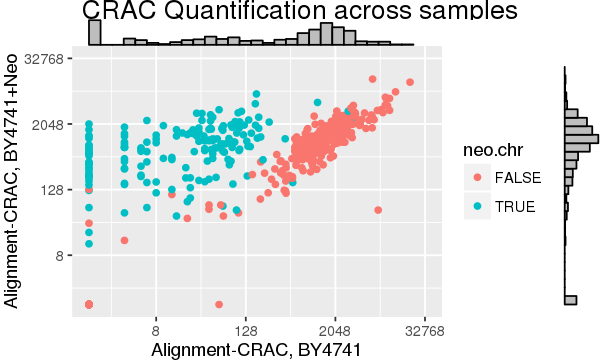

In [15]:
options(repr.plot.width = 5, repr.plot.height = 3)
p3

Other than tRNAs on the neochr, tRNA quantifications in Alignment-CRAC are highly similar across samples. Although again you can see a sizeable misquantification rate. All of the blue dots should be at 0 on x-axis!

# Fold change comparison

I thought that fold-changes (e.g. BY4741 + neo / BY4741) may be consistent between Salmon and alignment-based quantifications despite differences in absolute quantification levels. Basically, if the misquantification is consistent across samples, then fold-changes between samples should be the same across samples. 

In [16]:
relative.quant = df.merge %>% filter(!grepl("-neg",ezsample)) %>% group_by(note) %>% do({
    if (sum(is.na(.$salmon.TPM))>0) {
        return(data.frame())
    }
    s2.data = filter(.,sample=="S2")
    s3.data = filter(.,sample=="S3")
    note = unique(.$note)
    if (s2.data$salmon.TPM >= 1) {
        relative.tpm = s3.data$salmon.TPM/s2.data$salmon.TPM
    } else {
        relative.tpm = s3.data$salmon.TPM
    }
    if (s2.data$salmon.NumReads >= 1) {
        relative.numreads = s3.data$salmon.NumReads/s2.data$salmon.NumReads
    } else {
        relative.numreads = s3.data$salmon.NumReads
    }
     if (s2.data$value >= 1) {
        relative.crac = s3.data$value/s2.data$value
    } else {
        relative.crac = s3.data$value
    }
    o = data.frame(note, relative.tpm, relative.numreads, relative.crac)
    return(o)
})
relative.quant = ungroup(relative.quant)

In [17]:
p4 <- ggplot(relative.quant, aes(x=relative.numreads+1, y=relative.crac+1)) + geom_point() +
    geom_smooth(method = "lm", se = FALSE, formula = y ~ x) +
    scale_y_continuous(trans="log2") + 
    scale_x_continuous(trans="log2") +
    xlab("Fold-change\nSalmon-CRAC, NumReads") +
    ylab("Fold-change\nAlignment-CRAC-seq")

# Figure 4: Fold-change comparison Salmon-CRAC vs. Alignment-CRAC

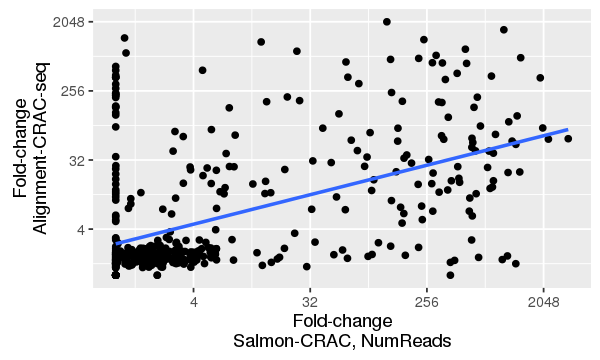

In [18]:
options(repr.plot.width = 5, repr.plot.height = 3)
p4

In [19]:
relative.quant %>%
    summarise(cor = cor(log2(relative.tpm+1),log2(relative.crac+1),use="complete"))

,cor
1,0.5078601


- Fold-change correlation between methods is slightly higher compared to correlation in raw data.
- This figure reinforces the observation that on average Salmon predicts more 0 quantifications. In addition, quantifications by salmon tend to be lower than with Alignment-based methods.